In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder

# Read the dataframe
df = pd.read_csv("data/dataframe.csv")

# Drop any rows with missing values
df = df.dropna()

# Split the data into input features (X) and target variable (y)
X = df.drop("y", axis=1).values
y = df["y"].values

In [11]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

#oversampler = RandomOverSampler(random_state=42)
#X_res, y_res = oversampler.fit_resample(X,y)

In [12]:
# Determine the number of unique critical error types
num_classes = len(np.unique(y))
print(num_classes)

# Encode the target variable using LabelEncoder and one-hot encoding
label_encoder = LabelEncoder()
y_res = label_encoder.fit_transform(y_res)
y_res = to_categorical(y_res)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

12


In [13]:
# Assuming X_train and X_test are your input data arrays
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Assuming y_train and y_test are your label arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(filters, kernel_size):
    # Create the FCN model
    model = Sequential()

    # Encoder
    model.add(Conv1D(filters, kernel_size, activation='relu', padding='same', input_shape=(78, 1)))
    model.add(Conv1D(filters, kernel_size, activation='relu', padding='same'))
    model.add(Conv1D(filters*2, kernel_size, activation='relu', padding='same'))
    model.add(Conv1D(filters*2, kernel_size, activation='relu', padding='same'))

    # Decoder
    model.add(Conv1D(filters, kernel_size, activation='relu', padding='same'))
    model.add(Conv1D(filters, kernel_size, activation='relu', padding='same'))

    # Global average pooling
    model.add(GlobalAveragePooling1D())

    # Dense layer for classification
    model.add(Dense(12, activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Print the model summary

model = create_model(64,3)

In [18]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

In [15]:
param_grid = {
    'filters': [64, 128, 256],
    'kernel_size': [3, 5],
    'batch_size': [16,32,64],
    'epochs': [10,25,50,100]
}

In [ ]:
import joblib
from sklearn.model_selection import GridSearchCV

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", cv=3, verbose=10, n_jobs=2)

# Enable verbose logging using joblib
joblib.parallel_backend('threading')

# Fit the grid search
grid_search.fit(X_train, y_train, validation_data=(X_train, y_train), callbacks=[earlystopping])

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3; 1/72] START batch_size=16, epochs=10, filters=64, kernel_size=3........
[CV 2/3; 1/72] START batch_size=16, epochs=10, filters=64, kernel_size=3........
Epoch 1/10
Epoch 1/10
239/529 [============>.................] - ETA: 21s - loss: 2.2636 - accuracy: 0.1959

In [19]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test), callbacks=[earlystopping])

Epoch 1/10
199/199 [==============================] - 28s 135ms/step - loss: 2.0730 - accuracy: 0.2524 - val_loss: 1.8401 - val_accuracy: 0.3368
Epoch 2/10
199/199 [==============================] - 40s 201ms/step - loss: 1.7583 - accuracy: 0.3850 - val_loss: 1.7003 - val_accuracy: 0.3791
Epoch 3/10
 46/199 [=====>........................] - ETA: 26s - loss: 1.6728 - accuracy: 0.4470

KeyboardInterrupt: 

In [37]:
import numpy as np
y_pred = model.predict(X_test)

y_pred_classes = []
y_real_classes = []

for item in y_pred:
    y_pred_classes.append(np.argmax(item))

for item in y_test:
    y_real_classes.append(np.argmax(item))
    
print(y_pred_classes[0])
print(y_real_classes[0])
# Assuming your classes are labeled from 0 to 25
predicted_class = np.argmax(y_pred[0])
probability = y_pred[0][predicted_class]

print("Predicted class:", predicted_class)
print("Probability:", probability)

100/100 [==============================] - 1s 9ms/step
2
2
Predicted class: 2
Probability: 0.6292625


In [38]:
import numpy as np
from sklearn.metrics import classification_report

print(classification_report(y_real_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.56      0.78      0.65       280
           1       0.75      0.60      0.67       253
           2       0.94      0.85      0.89       290
           3       0.76      0.76      0.76       277
           4       0.77      0.59      0.67       269
           5       0.99      0.77      0.87       247
           6       0.82      0.95      0.88       259
           7       0.71      0.69      0.70       251
           8       0.79      0.71      0.75       251
           9       0.63      0.97      0.76       266
          10       0.85      0.57      0.68       244
          11       0.67      0.71      0.69       284

    accuracy                           0.75      3171
   macro avg       0.77      0.75      0.75      3171
weighted avg       0.77      0.75      0.75      3171



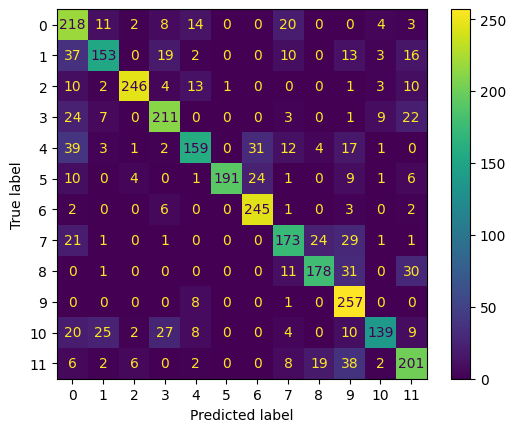

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_real_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()